In [1]:
#Lectura de datos

nombre_archivo = str(input('Ingrese el número de la instancia: '))+'.txt'
archivo = open(nombre_archivo,'r')
info = archivo.read()
archivo.close()

L = info.split()
V = int(L[0])
I = int(L[1])
C = int(L[2])
P = int(L[3])

id_instalacion = []
instalacion_xx = []
instalacion_yy = []
id_cliente = []
cliente_x = []
cliente_y = []
#recolectando la informacion de las instalaciones
for i in range(4,int(I)*3+4+1,3):
    id_instalacion.append(int(L[i]))
    instalacion_xx.append(float(L[i+1]))
    instalacion_yy.append(float(L[i+2]))
    
#recolectando la informacion de los clientes
for i in range(int(I)*3+4+3,int(C)*3+1+int(I)*3+4+1,3):
    id_cliente.append(int(L[i]))
    cliente_x.append(float(L[i+1]))
    cliente_y.append(float(L[i+2]))
    
#recolectando las capacidades de abastecimiento de las instalaciones
aux=int(int(C)*3+1+int(I)*3+4+1+1)
capacidad = []
completado = 0
while completado<2:
    abastece=int(L[aux+1])
    sub=[]
    for i in range(2,abastece+2):
        sub.append(L[aux+i])
    capacidad.append(sub)
    aux= aux+i+1
    completado=+1
    if aux==len(L):
        break
# p es una lista donde está la cantidad de clientes que abastece cada instalación        
p = [len(i) for i in capacidad]
B = []
for i in range(I):
    for elem in capacidad[i]:
        z = (int(elem),i+1)
        B.append(z)       
p.insert(0,0)
capacidad.insert(0,[])

Ingrese el número de la instancia: 32


In [2]:
import matplotlib                                     #importar bibliotecas necesarias
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [3]:
instalaciones = [i for i in range(1,I+1)]                                     #Se crean listas importantes para su posterior uso
clientes = [i for i in range(I+1,V)]
deposito_x = [instalacion_xx[0]]
deposito_y = [instalacion_yy[0]]
instalacion_x = [instalacion_xx[i] for i in range(1,len(instalacion_xx))]
instalacion_y = [instalacion_yy[i] for i in range(1,len(instalacion_yy))]

In [4]:
arcos = [(i,j) for i in id_instalacion for j in id_instalacion if i!=j]
distancia = {(i,j): np.hypot(instalacion_xx[i]-instalacion_xx[j], instalacion_yy[i]-instalacion_yy[j]) for i,j in arcos}

In [5]:
def distancia_total(lista,distancia):             #Funcion que calcula la distancia total de una lista
    dist=0
    for n in range(len(lista)-1):
        i=lista[n]
        j = lista[n+1]
        dist+=distancia[(i,j)]
    return dist

In [6]:
def heuristica(distancia,id_instalacion,P,capacidad):
    nodo_inicial = 0
    repetido=0
    solucion=[nodo_inicial]
    pRecolectado = 0
    visitados=[]
    fomes=[]
    while True:                         
        k=solucion[-1]
        for elem in capacidad[k]:
            if elem not in visitados:                  #Si el elemento no está en visitados suma un punto de beneficio
                pRecolectado+=1                        #esto es para que no se sume más de un punto por cada cliente.
                visitados.append(elem)
                
        if pRecolectado>=P:                            #Si cumple el beneficio requerido, retorna la lista solucion
            solucion.append(0)
            return solucion
        nn = {(k,j):distancia[(k,j)] for j in id_instalacion if k!=j and j not in solucion and j not in fomes}
        nuevo = min(nn.items(),key=lambda x:x[1])        #Añade a la lista solucion la instalacion que tenga la distancia mas corta
        solucion.append(nuevo[0][1])
        for elem in capacidad[nuevo[0][1]]:         #Esto es un proceso que agrega a una lista negra(fomes) instalaciones
            if elem in visitados:                   #que no aportan beneficio, y las elimina de la lista solucion
                repetido+=1
                if repetido==len(capacidad[nuevo[0][1]]):
                    fomes.append(nuevo[0][1])
                    solucion.remove(nuevo[0][1])
        repetido=0

In [7]:
def dos_opt(lista,distancia):                       #Algoritmo 2-opt
    sol_inicial = lista.copy() 
    cambio_minimo=0
    for i in range(len(sol_inicial)-2):
        for j in range(i+1,len(sol_inicial)-1):
            costo_actual=distancia[(sol_inicial[i],sol_inicial[i+1])]+distancia[(sol_inicial[j],sol_inicial[j+1])]
            costo_nuevo=distancia[(sol_inicial[i],sol_inicial[j])]+distancia[(sol_inicial[i+1],sol_inicial[j+1])]
            cambio_costo=costo_nuevo-costo_actual

            if cambio_costo<cambio_minimo:
                cambio_minimo=cambio_costo
                min_i=i
                min_j=j
    if cambio_minimo<0:
        sol_inicial[min_i+1:min_j+1]=sol_inicial[min_i+1:min_j+1][::-1]

    return sol_inicial

In [8]:
def dos_opete(solucion):                               #Algoritmo 2-opt hasta que desenrede toda la ruta
    sol=solucion.copy()
    cambio=1
    while cambio!=0:
        inicial=distancia_total(sol,distancia)
        sol= dos_opt(sol,distancia).copy()
        final=distancia_total(sol,distancia)
        cambio=np.abs(final-inicial)
    return sol

In [16]:
def cumple_el_beneficio(s,capacidad,P):              #Función que verifica si una lista solucion cumple el beneficio minimo
    n=len(s)                                        #requerido por el problema, si cumple: True, si no: False
    pRecolectado = 0                                
    visitados = []
    for i in range(1,n-1):
        for elem in (capacidad[s[i]]):
            if elem not in visitados:
                pRecolectado+=1
                visitados.append(elem)
    
    if pRecolectado>=P:
        return True
    else:
        return False
    
def no_esta_en_solucion(elem,solucion):                 #Función que verifica si un elemento no está en una lista
    if elem not in solucion and elem!=0:                #Si no está: True, si está: False
        return True
    else:
        return False
    
def perturbacion(solucion,capacidad,I):                #Perturbación utilizada en el problema
    n = len(solucion)
    nn = n
    a = int(np.floor((n-2)/2))
    instalaciones = [i for i in range(1,I+1)]
    for numero in range(a):                        #borra a instalaciones de la lista solución
        i= random.randint(1,n-2)
        del solucion[i]
        n-=1    
    while True:                  
        j = random.choice(instalaciones)              #genera instalaciones random que no esten en la lista solucion
        if no_esta_en_solucion(j,solucion):        
            solucion.insert(random.randint(1,n-2),j)      # y las agrega a la lista solucion en una posicion random
            n+=1
        else:
            while not no_esta_en_solucion(j,solucion):    #Si el elemento j esta en la lista solucion lo vuelve a generar
                j = random.choice(instalaciones)
            solucion.insert(random.randint(1,n-2),j)
            n+=1
        if cumple_el_beneficio(solucion,capacidad,P):    #Si la nueva lista cumple el beneficio, retorna esta lista
            return solucion


In [17]:
solucion = heuristica(distancia,id_instalacion,P,capacidad)        #Acá se aprecia la primera aproximación encontrada solo por
print(solucion)                                                    #La heuristica de solucion inicial
print(distancia_total(solucion,distancia))


[0, 1, 22, 20, 26, 29, 32, 33, 0]
26695.274334820453


# Grafico de la primera aproximación

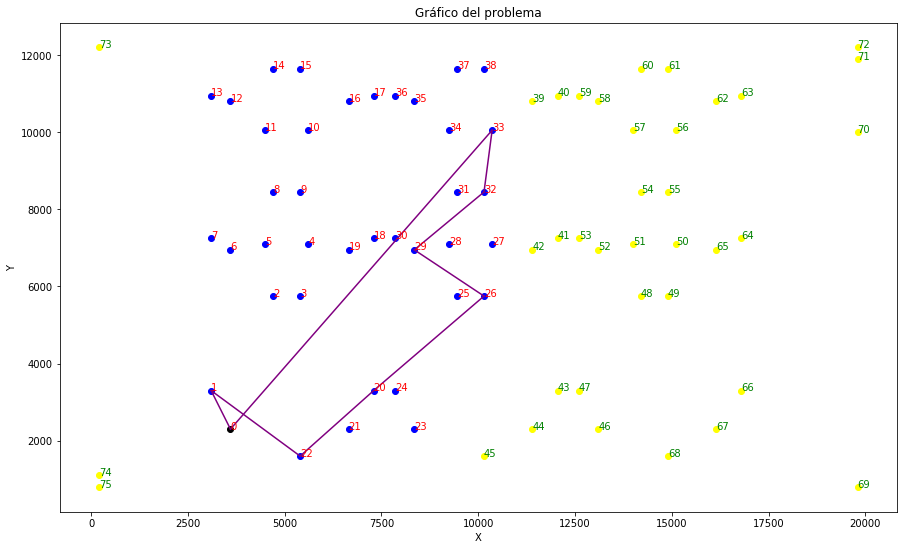

In [18]:
x = instalacion_x
y = instalacion_y


plt.figure(figsize=(15,9))

#graficando las instalaciones
plt.scatter(x,y,color='blue')
s=[]
for n in range(0,len(instalacion_x)):
    s_temp=[]
    s_temp.append("%.1f" %instalacion_x[n])
    s_temp.append("%.1f" %instalacion_y[n])
    s.append(s_temp)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gráfico del problema")

for n in range(0,len(instalacion_x)):
    plt.annotate(str(n+1), xy=(instalacion_x[n],instalacion_y[n] ), xytext=(instalacion_x[n],instalacion_y[n]+0.5), color='red')

    
#graficando los clientes    
f = []
a = cliente_x
b = cliente_y
plt.scatter(a,b,color='yellow')
for n in range(len(cliente_x)):
    f_temp=[]
    f_temp.append("%.1f" %cliente_x[n])
    f_temp.append("%.1f" %cliente_y[n])
    f.append(f_temp)
    
for n in range(I+1,I+1+C):
    plt.annotate(str(n), xy=(cliente_x[n-(I+1)],cliente_y[n-(I+1)] ), xytext=(cliente_x[n-(I+1)],cliente_y[n-(I+1)]+0.5), color='green')

#Graficando el depósito

plt.scatter(x=deposito_x,y=deposito_y,color='black')
dep_temp=["%.1f" %deposito_x[0],"%.1f" %deposito_y[0]]
plt.annotate(str(0), xy=(deposito_x[0],deposito_y[0] ), xytext=(deposito_x[0],deposito_y[0]+0.5), color='red')

#Graficando la solucion
for i in range (len(solucion)-1):
    plt.plot([instalacion_xx[solucion[i]], instalacion_xx[solucion[i+1]]],[instalacion_yy[solucion[i]],instalacion_yy[solucion[i+1]]],color='purple')

#COLORES: Negro: Depósito, Azul: Instalaciones, Amarillo: Clientes

plt.show()

In [20]:
#Iterated Local Search
iteracion_max = 500
random.seed(0)
lista_valores = []
inicioTiempo = time.time()                                  #inicia contador de tiempo
s = heuristica(distancia,id_instalacion,P,capacidad)        #solucion inicial
s = dos_opete(s)                                           #busqueda local
costoMejor = distancia_total(s,distancia)                  #se actualiza la mejor solucion
s_mejor = s[:]
for iteracion in range(iteracion_max):                    #repeat hasta criterio de termino (numero max de iteraciones)
    s = perturbacion(s,capacidad,I)                       #perturbacion
    s = dos_opete(s)                                      #búsqueda local
    costoCandidato = distancia_total(s,distancia)   
    lista_valores.append(costoCandidato)                   #se calcula el costo de la solucion
    print("%d\t%d" % (iteracion+1, costoCandidato))
    if costoCandidato < costoMejor:                       #criterio de aceptacion
        s_mejor = s[:]                                   #se actualiza la mejor solucion
        costoMejor = costoCandidato
finalTiempo = time.time()
tiempo = finalTiempo - inicioTiempo                      #termina contador de tiempo
print("Tiempo : %f" % tiempo)
print("Costo  : ",costoMejor)
print('La ruta asociada es', s_mejor)

1	28964
2	30704
3	27764
4	25310
5	25460
6	37432
7	32651
8	35704
9	44953
10	41571
11	43717
12	33049
13	28139
14	35907
15	27401
16	46733
17	38912
18	32773
19	39261
20	39723
21	46882
22	41909
23	37100
24	38344
25	36995
26	34144
27	28665
28	34826
29	32964
30	39243
31	40206
32	30796
33	38940
34	31516
35	30101
36	29022
37	39194
38	36418
39	26389
40	37867
41	39457
42	31386
43	42510
44	44378
45	34960
46	29106
47	26327
48	32947
49	42557
50	29335
51	38371
52	32401
53	32199
54	36792
55	31699
56	37193
57	41622
58	38906
59	31587
60	38519
61	29275
62	29346
63	29181
64	27433
65	40538
66	31198
67	23466
68	31413
69	29802
70	42378
71	36745
72	27594
73	25560
74	35162
75	39384
76	38763
77	38080
78	39137
79	30431
80	41964
81	33746
82	45578
83	35866
84	24093
85	26053
86	32359
87	38002
88	34792
89	41055
90	35790
91	40564
92	31917
93	41930
94	32789
95	35151
96	32056
97	30829
98	26489
99	26095
100	24092
101	46193
102	38493
103	44433
104	30860
105	40725
106	39581
107	37541
108	29363
109	35139
110	44723
111	3547

# Gráfico de la solución encontrada

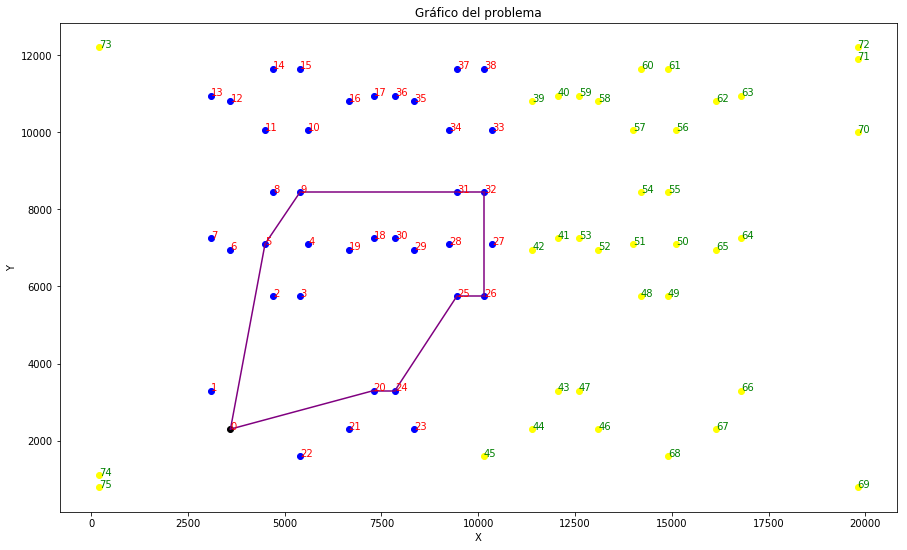

In [13]:
x = instalacion_x
y = instalacion_y


plt.figure(figsize=(15,9))

#graficando las instalaciones
plt.scatter(x,y,color='blue')
s=[]
for n in range(0,len(instalacion_x)):
    s_temp=[]
    s_temp.append("%.1f" %instalacion_x[n])
    s_temp.append("%.1f" %instalacion_y[n])
    s.append(s_temp)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gráfico del problema")

for n in range(0,len(instalacion_x)):
    plt.annotate(str(n+1), xy=(instalacion_x[n],instalacion_y[n] ), xytext=(instalacion_x[n],instalacion_y[n]+0.5), color='red')

    
#graficando los clientes    
f = []
a = cliente_x
b = cliente_y
plt.scatter(a,b,color='yellow')
for n in range(len(cliente_x)):
    f_temp=[]
    f_temp.append("%.1f" %cliente_x[n])
    f_temp.append("%.1f" %cliente_y[n])
    f.append(f_temp)
    
for n in range(I+1,I+1+C):
    plt.annotate(str(n), xy=(cliente_x[n-(I+1)],cliente_y[n-(I+1)] ), xytext=(cliente_x[n-(I+1)],cliente_y[n-(I+1)]+0.5), color='green')

#Graficando el depósito

plt.scatter(x=deposito_x,y=deposito_y,color='black')
dep_temp=["%.1f" %deposito_x[0],"%.1f" %deposito_y[0]]
plt.annotate(str(0), xy=(deposito_x[0],deposito_y[0] ), xytext=(deposito_x[0],deposito_y[0]+0.5), color='red')

#Graficando la solucion
for n in range (len(s_mejor)-1):
    plt.plot([instalacion_xx[s_mejor[n]], instalacion_xx[s_mejor[n+1]]],[instalacion_yy[s_mejor[n]],instalacion_yy[s_mejor[n+1]]],color='purple')

#COLORES: Negro: Depósito, Azul: Instalaciones, Amarillo: Clientes

plt.show()